# Dataset Creation

## Aim
Create a dataset for **future analysis**.

---

## Necessary Downloads
Before starting, be sure to have downloaded the following material.

### 1. MSigDB Gene Sets (Human)
Download the entire MSigDB for **Human** in **JSON** format (`Human Gene Set JSON file set (ZIPped)`).
- **Link**: [https://www.gsea-msigdb.org/gsea/downloads.jsp](https://www.gsea-msigdb.org/gsea/downloads.jsp)

### 2. UniProt Human Proteome
Download the list of all **HUMAN proteins** (UniProt human proteome - **UP000005640**).
- **Link (Website)**: [https://www.uniprot.org/proteomes/UP000005640](https://www.uniprot.org/proteomes/UP000005640)
- **Programmatic Download (Terminal)**:

```bash
wget -O human_proteome.tsv.gz "[https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession,reviewed,id,protein_name,gene_names,organism_name,sequence&format=tsv&query=(proteome:UP000005640](https://rest.uniprot.org/uniprotkb/stream?compressed=true&fields=accession,reviewed,id,protein_name,gene_names,organism_name,sequence&format=tsv&query=(proteome:UP000005640))"
gunzip human_proteome.tsv.gz
```

<!-- ### 3. UniProt Gene-Protein mapping

[UniProt protein-gene Mapping](https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping.dat.gz)


### 3. UniRef50 Clusters

#### A. Initial Programmatic Download (Partial)
This method retrieves all clusters with at least one human protein, but is a **subsample** of the full UniRef50.
- **Link (Website)**: [https://www.uniprot.org/uniref?query=%28identity%3A0.5%29+AND+%28taxonomy_id%3A9606%29](https://www.uniprot.org/uniref?query=%28identity%3A0.5%29+AND+%28taxonomy_id%3A9606%29)
- **Programmatic Download (Terminal)**:
    - **ATTENTION**: This call retrieves all clusters with at least 1 human protein, *not* just the human proteins themselves.

```bash
curl -o uniref50_human.tsv.gz "[https://rest.uniprot.org/uniref/stream?compressed=true&fields=id,name,organism,length,identity,count,members&format=tsv&query=((identity:0.5)+AND+(taxonomy_id:9606](https://rest.uniprot.org/uniref/stream?compressed=true&fields=id,name,organism,length,identity,count,members&format=tsv&query=((identity:0.5)+AND+(taxonomy_id:9606)))"
gunzip uniref50_human.tsv.gz
``` -->

<!-- ### 5. BioMart Gene-Protein mapping

Download BioMart gne-protein mapping, besure to include **Gene Name** and **Transcript Name**.
[link](https://www.ensembl.org/biomart/martview/3aaaf734b93facdfad8207234204cc31) -->


# Differences

- OK: no "PROLIFERATION"| CDK5 |CANCER| APOPTOSIS-- much stringet find
- OK: do not care about crucial for mitosis, but not for controlling whether or when mitosis happens. (ex spidnle) They are executors, not decision-makers.
    - recome cell cycle is too broad!!!
    - My concern is that including genes encoding structural machinery might introduce too much variability for the model to learn effectively.
- OK: not use as negative proteisn in the same lcuster as postive
    - Cluster UniRef50_Q5VXH4 contains proteins [Q5VXH4, A3QJZ7, Q5VWM4]
    - Say 2 are labeled positive, 1 is labeled negative
    - ut this isn't learning cell-cycle function — it's learning "this cluster tends to be cell-cycle"
    - his creates an impossible learning problem. The model can't possibly learn that these should have different labels because there's almost no signal in the embeddings to distinguish them.
- change egative class:
    - Negative = "protein annotated to genes known to be involved in non-cell-cycle pathways"
        - For example: neuronal proteins, muscle-specific proteins, proteins involved in cell death/apoptosis, structural proteins
        - "neuronal development," "muscle differentiation," "extracellular matrix"
    - or housekeep genes
- OK: do not sample psotve genes 8take all)
- OK: aplit by  cluster in train/test -- no dataleackage


CONCENRS
- false negative: : Just because a gene wasn't in your MSigDB search doesn't mean the protein isn't involved in cell-cycle.
- Genes that appear in ambiguous frequency aren't necessarily non-cell-cycle



## Hyperparameters

In [1]:
import json
import os
import re
import pandas as pd
import numpy as np
from scipy.special import softmax
from sklearn.model_selection import train_test_split
import random
import torch

import utils.dataset_functions as dataf

# Initializations
SEED=42
random.seed(SEED)
np.random.seed(SEED)

# Directory containing MSigDB JSON files
JSON_DIR = "/home/gdallagl/myworkdir/data/MSigDB/msigdb_v2025.1.Hs_json_files_to_download_locally"

# cellcycel geensets saving apth
CELL_CYCLE_CSV_PATH = "/home/gdallagl/myworkdir/data/MSigDB/cell_cycle_genesets.csv"

# Garated genes list
GUARANTEED_GENES_PATH = "/home/gdallagl/myworkdir/data/MSigDB/julies_cycling_signatures_cancer.tsv"

# Updated keywords pattern with word boundaries to avoid false matches
# KEYWORDS_PATTERN = "|".join([
#     # core terms
#     "CELL_CYCLE",
#     "_CYCLING",  # avoid "recycling"
#     "_CC_",      # often denotes "cell cycle"
    
#     # phases
#     "_G0_", "_G1_", "_S_PHASE_", "_G2_", "_M_PHASE_",
#     "INTERPHASE", "PROMETAPHASE", "METAPHASE", "ANAPHASE", "TELOPHASE",

#     # regulators and enzymes
#     "CDK", "CYCLIN", 
#     #"CHK1", "CHK2", "ATM", "ATR", "PLK1", "AURORA", "BUB1", "BUBR1", "CDC", "WEE1", "CDC25", "CCNB", "CCNA", "CCND", "CCNE",
    
#     # structural components
#     "SPINDLE", "MICROTUBULE", "CENTROSOME", "CENTROMERE", "KINETOCHORE",
#     "CHROMATID", "CHROMOSOME_SEGREGATION", "CONDENSIN", "COHESIN",

#     # events and checkpoints
#     "CHECKPOINT", #"DNA_REPLICATION", "DNA_SYNTHESIS", 
#     "CYTOKINESIS", "NUCLEAR_DIVISION", "CHROMOSOME_SEPARATION", 
#     "SISTER_CHROMATID", "REPLICATION_FORK", "MITOTIC_EXIT",

#     # gene ontology or pathway terms
#     "M_PHASE", "G1_S", "G2_M", "S_M_TRANSITION",
#     "CELL_DIVISION", "CELL_CYCLE_PROCESS"
#     #"PROLIFERATION"
# ])
KEYWORDS_PATTERN = "|".join([
    # Key regulatory phrases
    "_CELL_CYCLE_CHECKPOINT",
    "CELL_CYCLE_REGULATION",
    "CELL_CYCLE_CONTROL",

    "HALLMARK_E2F_TARGETS", 
    " HALLMARK_G2M_CHECKPOINT",
    # Core regulators
    "CDK", "_CYCLIN",

    # Transitions
    "_G1_S", "G1_S_", "G2_M", "_S_PHASE_", "M_PHASE", "MITOTIC_CHECKPOINT"
])


# Exclusion pattern
EXCLUSION_PATTERN = r"MEIOTIC|MEIOSIS|FATTY_ACID_CYCLING_MODEL|CDK5|CANCER|APOPTOSIS|RECYCLING|SPINDLE|KINETOCHORE|CYTOKINESIS|CENTROSOME|KEGG_MEDICUS_PATHOGEN|KEGG_MEDICUS_VARIANT|KEGG_MEDICUS_REFERENCE|PREDICTED|HE_LIM_SUN_FETAL_LUNG|MALIGNANT|MORF_CDK2"

# Human proteome path
HUMAN_PROTEOME_PATH = "/home/gdallagl/myworkdir/data/UniRef50/human_proteome.tsv"

# # Uniref Apth
# UNIREF_PATH = "/home/gdallagl/myworkdir/ESMSec/data/UniRef50/uniref_identity_0_5_AND_taxonomy_id_2025_10_08.tsv" 

# mapping protein-gene apth
MAPPING_PATH = "/home/gdallagl/myworkdir/ESMSec/data/UniRef50/HUMAN_9606_idmapping.dat"

# Minimum frequency threshold for filtering ambiguous genes
MIN_FREQ_AMBIGOUS = 2

# min number of postive samples per positive cluster
MIN_SAMPLE_N_POSITIVE = 2

# how many mroe negativ class to sampel
NEGATIVE_CLASS_MULT = 3

# choose if use as postive class only the guaranted genes
ONLY_GUARANTEED = False
only_guaranteed = "only-guaranteed_" if ONLY_GUARANTEED else ""

# savifn csv datset
FINAL_DATASET_PATH = f"/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/gabri_dataset-cell-cycle_{only_guaranteed}{MIN_SAMPLE_N_POSITIVE}:{NEGATIVE_CLASS_MULT}.csv"
print(FINAL_DATASET_PATH)

# Autorelaod
%load_ext autoreload
%autoreload 2

/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/gabri_dataset-cell-cycle_2:3.csv


## Select pathways related to cell cycle

Read the MSigDB and select all pathways with keyword related to field of interest.

In [2]:
### 1) Transform jsons into df
df_genesets = dataf.load_json_folder_to_df(JSON_DIR)
df_genesets = df_genesets.drop_duplicates(subset=['set_name'], keep='first')
display(df_genesets.head(2)); print(df_genesets.shape)

,set_name,collection,systematicName,pmid,exactSource,externalDetailsURL,msigdbURL,geneSymbols,filteredBySimilarity,externalNamesForSimilarTerms,source_file
0,MIR153_5P,C3:MIR:MIRDB,M30412,31504780,,http://mirdb.org/cgi-bin/mature_mir.cgi?name=h...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[A1CF, AAK1, AASDHPPT, ABCE1, ABHD2, ABI2, ACB...",[],[],c3.mir.mirdb.v2025.1.Hs.json
1,MIR8485,C3:MIR:MIRDB,M30413,31504780,,http://mirdb.org/cgi-bin/mature_mir.cgi?name=h...,https://www.gsea-msigdb.org/gsea/msigdb/human/...,"[AAK1, ABHD18, ABL2, ABLIM1, ACVR1, ACVR2B, AC...",[],[],c3.mir.mirdb.v2025.1.Hs.json


(35134, 11)


In [9]:
### 2) Select only geneset related to interested fiedl
mask_include = df_genesets["set_name"].str.contains(KEYWORDS_PATTERN, case=False, regex=True)
mask_exclude = df_genesets["set_name"].str.contains(EXCLUSION_PATTERN, case=False, regex=True)
genesets_cell_cycle = df_genesets[mask_include & ~mask_exclude].copy()

genesets_cell_cycle.to_csv(CELL_CYCLE_CSV_PATH)

print(genesets_cell_cycle.shape)
list(genesets_cell_cycle['set_name'].sort_values())

(68, 11)


['BENPORATH_CYCLING_GENES',
 'FISCHER_G1_S_CELL_CYCLE',
 'FISCHER_G2_M_CELL_CYCLE',
 'GNF2_CDKN1C',
 'GOBP_CELL_CYCLE_CHECKPOINT_SIGNALING',
 'GOBP_CELL_CYCLE_G1_S_PHASE_TRANSITION',
 'GOBP_CELL_CYCLE_G2_M_PHASE_TRANSITION',
 'GOBP_MITOTIC_CELL_CYCLE_CHECKPOINT_SIGNALING',
 'GOBP_MITOTIC_G1_S_TRANSITION_CHECKPOINT_SIGNALING',
 'GOBP_MITOTIC_G2_M_TRANSITION_CHECKPOINT',
 'GOBP_NEGATIVE_REGULATION_OF_CELL_CYCLE_CHECKPOINT',
 'GOBP_NEGATIVE_REGULATION_OF_CELL_CYCLE_G1_S_PHASE_TRANSITION',
 'GOBP_NEGATIVE_REGULATION_OF_CELL_CYCLE_G2_M_PHASE_TRANSITION',
 'GOBP_NEGATIVE_REGULATION_OF_CYCLIN_DEPENDENT_PROTEIN_KINASE_ACTIVITY',
 'GOBP_NEGATIVE_REGULATION_OF_CYCLIN_DEPENDENT_PROTEIN_SERINE_THREONINE_KINASE_ACTIVITY',
 'GOBP_POSITIVE_REGULATION_OF_CELL_CYCLE_CHECKPOINT',
 'GOBP_POSITIVE_REGULATION_OF_CELL_CYCLE_G1_S_PHASE_TRANSITION',
 'GOBP_POSITIVE_REGULATION_OF_CELL_CYCLE_G2_M_PHASE_TRANSITION',
 'GOBP_POSITIVE_REGULATION_OF_G1_S_TRANSITION_OF_MITOTIC_CELL_CYCLE',
 'GOBP_REGULATION_OF_CELL_C

In [47]:
ok_gs = ['BENPORATH_CYCLING_GENES',
 'FISCHER_G1_S_CELL_CYCLE',
 'FISCHER_G2_M_CELL_CYCLE',
 'GOBP_CELL_CYCLE_CHECKPOINT_SIGNALING',
 'GOBP_CELL_CYCLE_G1_S_PHASE_TRANSITION',
 'GOBP_CELL_CYCLE_G2_M_PHASE_TRANSITION',
 'GOBP_MITOTIC_CELL_CYCLE_CHECKPOINT_SIGNALING',
 'GOBP_MITOTIC_G1_S_TRANSITION_CHECKPOINT_SIGNALING',
 'GOBP_MITOTIC_G2_M_TRANSITION_CHECKPOINT',
 'GOBP_NEGATIVE_REGULATION_OF_CELL_CYCLE_CHECKPOINT',
 'GOBP_NEGATIVE_REGULATION_OF_CELL_CYCLE_G1_S_PHASE_TRANSITION',
 'GOBP_NEGATIVE_REGULATION_OF_CELL_CYCLE_G2_M_PHASE_TRANSITION',
 'GOBP_NEGATIVE_REGULATION_OF_CYCLIN_DEPENDENT_PROTEIN_KINASE_ACTIVITY',
 'GOBP_NEGATIVE_REGULATION_OF_CYCLIN_DEPENDENT_PROTEIN_SERINE_THREONINE_KINASE_ACTIVITY',
 'GOBP_POSITIVE_REGULATION_OF_CELL_CYCLE_CHECKPOINT',
 'GOBP_POSITIVE_REGULATION_OF_CELL_CYCLE_G1_S_PHASE_TRANSITION',
 'GOBP_POSITIVE_REGULATION_OF_CELL_CYCLE_G2_M_PHASE_TRANSITION',
 'GOBP_POSITIVE_REGULATION_OF_G1_S_TRANSITION_OF_MITOTIC_CELL_CYCLE',
 'GOBP_REGULATION_OF_CELL_CYCLE_CHECKPOINT',
 'GOBP_REGULATION_OF_CELL_CYCLE_G1_S_PHASE_TRANSITION',
 'GOBP_REGULATION_OF_CELL_CYCLE_G2_M_PHASE_TRANSITION',
 'GOBP_REGULATION_OF_CYCLIN_DEPENDENT_PROTEIN_SERINE_THREONINE_KINASE_ACTIVITY',
 'GOBP_RESPONSE_TO_CELL_CYCLE_CHECKPOINT_SIGNALING',
#  'GOCC_CYCLIN_CDK_POSITIVE_TRANSCRIPTION_ELONGATION_FACTOR_COMPLEX',
 'GOCC_CYCLIN_DEPENDENT_PROTEIN_KINASE_HOLOENZYME_COMPLEX',
 'GOCC_NUCLEAR_CYCLIN_DEPENDENT_PROTEIN_KINASE_HOLOENZYME_COMPLEX',
 'GOMF_CYCLIN_BINDING',
 'GOMF_CYCLIN_DEPENDENT_PROTEIN_KINASE_ACTIVITY',
 'GOMF_CYCLIN_DEPENDENT_PROTEIN_SERINE_THREONINE_KINASE_ACTIVATOR_ACTIVITY',
 'GOMF_CYCLIN_DEPENDENT_PROTEIN_SERINE_THREONINE_KINASE_INHIBITOR_ACTIVITY',
 'GOMF_CYCLIN_DEPENDENT_PROTEIN_SERINE_THREONINE_KINASE_REGULATOR_ACTIVITY',
 'HALLMARK_E2F_TARGETS',
 'MOLENAAR_TARGETS_OF_CCND1_AND_CDK4_DN',
 'MOLENAAR_TARGETS_OF_CCND1_AND_CDK4_UP',
#  'PULVER_FOREY_CELLCYCLE_ENRICHED_TFS_G1_S',
#  'PULVER_FOREY_CELLCYCLE_ENRICHED_TFS_G2_M',
#  'PULVER_FOREY_CELLCYCLE_PEAKING_G1_S',
#  'PULVER_FOREY_CELLCYCLE_PEAKING_G2_M',
#  'PULVER_FOREY_PERTURB_ACCUMULATION_G1_S',
#  'PULVER_FOREY_PERTURB_ACCUMULATION_G2_M',
#  'PULVER_FOREY_PERTURB_ATTRITION_G1_S',
#  'PULVER_FOREY_PERTURB_ATTRITION_G2_M',
 'REACTOME_APC_C_CDC20_MEDIATED_DEGRADATION_OF_CYCLIN_B',
 'REACTOME_CDK_MEDIATED_PHOSPHORYLATION_AND_REMOVAL_OF_CDC6',
 'REACTOME_CELL_CYCLE_CHECKPOINTS',
 'REACTOME_CHK1_CHK2_CDS1_MEDIATED_INACTIVATION_OF_CYCLIN_B_CDK1_COMPLEX',
 'REACTOME_CYCLIN_A_B1_B2_ASSOCIATED_EVENTS_DURING_G2_M_TRANSITION',
 'REACTOME_CYCLIN_A_CDK2_ASSOCIATED_EVENTS_AT_S_PHASE_ENTRY',
 'REACTOME_CYCLIN_D_ASSOCIATED_EVENTS_IN_G1',
#  'REACTOME_DRUG_MEDIATED_INHIBITION_OF_CDK4_CDK6_ACTIVITY',
 'REACTOME_G1_S_DNA_DAMAGE_CHECKPOINTS',
 'REACTOME_G1_S_SPECIFIC_TRANSCRIPTION',
 'REACTOME_G2_M_CHECKPOINTS',
 'REACTOME_G2_M_DNA_DAMAGE_CHECKPOINT',
 'REACTOME_G2_M_DNA_REPLICATION_CHECKPOINT',
 'REACTOME_MITOTIC_G1_PHASE_AND_G1_S_TRANSITION',
 'REACTOME_MITOTIC_G2_G2_M_PHASES',
 'REACTOME_M_PHASE',
 'REACTOME_REGULATION_OF_PLK1_ACTIVITY_AT_G2_M_TRANSITION',
 'REACTOME_RUNX3_REGULATES_CDKN1A_TRANSCRIPTION',
 'REACTOME_THE_ROLE_OF_GTSE1_IN_G2_M_PROGRESSION_AFTER_G2_CHECKPOINT',
 'REACTOME_UBIQUITIN_DEPENDENT_DEGRADATION_OF_CYCLIN_D',
 'SA_G2_AND_M_PHASES',
 'SA_REG_CASCADE_OF_CYCLIN_EXPR',
 'WHITFIELD_CELL_CYCLE_G1_S',
 'WHITFIELD_CELL_CYCLE_G2_M',
 'WP_G1_TO_S_CELL_CYCLE_CONTROL']


genesets_cell_cycle = genesets_cell_cycle[genesets_cell_cycle['set_name'].isin(ok_gs)]
genesets_cell_cycle.shape

(57, 11)

### Count in how many genesets each gene is present

Needed for later to calculate probability for sampling.

In [48]:
gene_counts_df = dataf.gene_set_counts(genesets_cell_cycle)

# if only_guaranteed in ture takeonly one gene of the one extarcted form MSigDB
if ONLY_GUARANTEED:
    gene_counts_df = gene_counts_df.iloc[[0], :]

display(gene_counts_df)
print(gene_counts_df.gene.to_list())

,gene,geneset_count
0,CDK1,28
1,CCNB1,27
2,CDKN1A,27
3,CCND1,23
4,CDK2,22
...,...,...
1876,TMCO4,1
1877,ZFX,1
1878,MBOAT1,1
1879,NEAT1,1


['CDK1', 'CCNB1', 'CDKN1A', 'CCND1', 'CDK2', 'CDC6', 'CCNE1', 'CCNA2', 'CDC25A', 'WEE1', 'CDKN1B', 'CCNE2', 'CCNA1', 'TP53', 'CCNB2', 'PLK1', 'CDK4', 'RPA2', 'CDKN2A', 'BARD1', 'CHEK1', 'UBA52', 'CHEK2', 'CDK7', 'BRCA1', 'MNAT1', 'CDKN2D', 'ORC1', 'E2F1', 'UBC', 'RPS27A', 'UBB', 'FZR1', 'CCNH', 'CCND3', 'CDKN2C', 'AURKB', 'TOPBP1', 'CDC25C', 'RBBP8', 'PSMD11', 'BLM', 'DTL', 'BIRC5', 'CCND2', 'CENPF', 'ATM', 'CDC25B', 'CLSPN', 'CKS1B', 'RAD50', 'PSMD13', 'PSMD14', 'PSMD3', 'PSMD7', 'SEM1', 'PSMD6', 'PSMC3', 'PSMC5', 'PSMC1', 'NBN', 'PSMA7', 'PSMA5', 'RB1', 'PSMD8', 'PSMD2', 'PSMB7', 'PSMB1', 'PSMB3', 'PSMB2', 'PSMB4', 'PSMB5', 'PSMC4', 'ADRM1', 'CDCA8', 'PSMA3', 'PSMA2', 'PSMA4', 'PSMD12', 'NDC80', 'PSMC2', 'PSMB6', 'BRCC3', 'PSMC6', 'PSMD1', 'HUS1', 'MRE11', 'BABAM2', 'PSMA6', 'PKMYT1', 'PSMA1', 'MAD2L1', 'AURKA', 'PPP2CA', 'TFDP1', 'CDK6', 'CDKN2B', 'ATR', 'DONSON', 'RRM2', 'RAD17', 'ABRAXAS1', 'CDC7', 'BABAM1', 'UIMC1', 'CDK10', 'CKS2', 'MCM5', 'TRIM39', 'APC', 'PCNA', 'CDC45', 'TREX

### Filter out genes with too few Gene Sets

In [49]:
# give a label to gene that overcome the thr
gene_counts_df["label"] = gene_counts_df.geneset_count.apply(lambda x: 'positive' if x > MIN_FREQ_AMBIGOUS else 'ambigous')

# create a label for later
gene_counts_df["is_guaranteed"] = False

display(gene_counts_df)
print(gene_counts_df.label.value_counts())

,gene,geneset_count,label,is_guaranteed
0,CDK1,28,positive,False
1,CCNB1,27,positive,False
2,CDKN1A,27,positive,False
3,CCND1,23,positive,False
4,CDK2,22,positive,False
...,...,...,...,...
1876,TMCO4,1,ambigous,False
1877,ZFX,1,ambigous,False
1878,MBOAT1,1,ambigous,False
1879,NEAT1,1,ambigous,False


label
ambigous    1118
positive     763
Name: count, dtype: int64


### Add Guaranteed genes

Add genes related to interesting field (i.e. that msut be present).

Read them from csv file.

Add them with max-freq.

In [6]:
# ### 1) Read spefic csv
# garanted_genes_df = pd.read_csv(GUARANTEED_GENES_PATH, sep='\t')
# display(garanted_genes_df.head(5))

# ### 2) Extarct the single gene names
# all_values = garanted_genes_df.to_numpy().flatten().tolist()
# all_values = [x for x in all_values if pd.notna(x)] # remove nan
# all_values = list(set(all_values)) # remove duplicated
# print("Number of guaranted genes: ", len(all_values))

# ### 3) Add them into previus df
# # create a DataFrame for new genes
# new_genes_df = pd.DataFrame({
#     'gene': all_values,
#     'geneset_count': max(gene_counts_df.geneset_count), # Use as Freq the max (as these genes are guaranted)
#     'label': "positive",
#     "is_guaranteed": True
# })

# # append to existing gene_frequency_df
# gene_frequency_df = pd.concat([gene_counts_df, new_genes_df], ignore_index=True)

# # ATTENTION: Drop duplicates, keeping **the last occurrence** (i.e., from new_genes_df) --< so gurated genes have max freq
# gene_frequency_df = gene_frequency_df.drop_duplicates(subset='gene', keep='last')

# # Sort and reset index
# gene_frequency_df.sort_values(by=['geneset_count', 'gene'], ascending=[False, True], inplace=True)
# gene_frequency_df.reset_index(drop=True, inplace=True)

# # create lists of genes
# ambiguos_genes = set(gene_frequency_df[gene_frequency_df.label == "ambigous"].gene)
# positive_genes = set(gene_frequency_df[gene_frequency_df.label == "positive"].gene)

# display(gene_frequency_df)

# print(gene_frequency_df.is_guaranteed.value_counts())
# print("\nTotal genes of cell cycle program:", gene_frequency_df.gene.nunique())

In [14]:
gene_frequency_df=gene_counts_df

# create lists of genes
ambiguos_genes = set(gene_frequency_df[gene_frequency_df.label == "ambigous"].gene)
positive_genes = set(gene_frequency_df[gene_frequency_df.label == "positive"].gene)

display(gene_frequency_df)

print(gene_frequency_df.is_guaranteed.value_counts())
print("\nTotal genes of cell cycle program:", gene_frequency_df.gene.nunique())

,gene,geneset_count,label,is_guaranteed
0,CCNB1,28,positive,False
1,CDK1,28,positive,False
2,CDKN1A,27,positive,False
3,CCND1,25,positive,False
4,CDK2,23,positive,False
...,...,...,...,...
4630,ZNF740,1,ambigous,False
4631,ZNF7,1,ambigous,False
4632,ZNF692,1,ambigous,False
4633,ZNF83,1,ambigous,False


is_guaranteed
False    4635
Name: count, dtype: int64

Total genes of cell cycle program: 4635


### Create mapping positive-gene --> geneset-freq

In [15]:
# make postive gene-freq mapping
# Filter only positive genes
positive_genes_df = gene_frequency_df[gene_frequency_df["label"] == "positive"]
# Create a mapping: gene -> frequency
positive_gene_freq_map = dict(zip(positive_genes_df["gene"], positive_genes_df["geneset_count"]))
positive_gene_freq_map

{'CCNB1': 28,
 'CDK1': 28,
 'CDKN1A': 27,
 'CCND1': 25,
 'CDK2': 23,
 'CDC6': 22,
 'WEE1': 21,
 'CDC25A': 21,
 'CCNE2': 21,
 'CCNE1': 21,
 'CCNA2': 21,
 'CDKN1B': 19,
 'CCNB2': 18,
 'CCNA1': 18,
 'PLK1': 17,
 'TP53': 17,
 'CDK4': 16,
 'FZR1': 15,
 'E2F1': 15,
 'CCND3': 15,
 'RPA2': 15,
 'CDKN2A': 15,
 'BARD1': 15,
 'ORC1': 15,
 'TOPBP1': 14,
 'RB1': 14,
 'CHEK1': 14,
 'UBB': 13,
 'RBBP8': 13,
 'UBA52': 13,
 'UBC': 13,
 'RPS27A': 13,
 'MNAT1': 13,
 'CHEK2': 13,
 'CDKN2D': 13,
 'BRCA1': 13,
 'CDK7': 13,
 'DTL': 13,
 'CDC25B': 13,
 'TFDP1': 12,
 'CDC25C': 12,
 'CLSPN': 12,
 'DONSON': 12,
 'AURKB': 12,
 'CCND2': 12,
 'CDKN2C': 12,
 'BLM': 12,
 'PSMD13': 12,
 'CCNH': 12,
 'PSMD11': 12,
 'BIRC5': 12,
 'CENPF': 11,
 'ATM': 11,
 'CKS1B': 11,
 'PPP2CA': 11,
 'UIMC1': 11,
 'PSMD3': 11,
 'MCM6': 11,
 'NBN': 11,
 'HUS1': 11,
 'PSMA3': 11,
 'PSMC2': 11,
 'BABAM2': 11,
 'CDCA8': 11,
 'MRE11': 11,
 'PSMD7': 11,
 'MCM2': 11,
 'PSMB5': 10,
 'PSMD12': 10,
 'PSMD14': 10,
 'PSMB4': 10,
 'TICRR': 10,
 'NDC

## Protein-Gene mapping

As MSigDB has genes, while Uniref50 uses proteins, we need a mapping.

Use UniProt Human Proteome.

In [16]:
proteome_uniprot = pd.read_csv(HUMAN_PROTEOME_PATH, sep="\t")
proteome_uniprot_reviewed = proteome_uniprot[proteome_uniprot.Reviewed == "reviewed"]

# lst all allowed proteins to use
all_uniprot_reviewed_proteins = set(proteome_uniprot_reviewed.Entry.unique())

# protein to gene mapping
    # ATTENTIon: mapping will have only human  curate genes
protein_to_gene_map = proteome_uniprot_reviewed.set_index('Entry')['Gene Names'].dropna().to_dict()

display(proteome_uniprot_reviewed.head(5)); print(proteome_uniprot_reviewed.shape)

,Entry,Reviewed,Entry Name,Protein names,Gene Names,Organism,Sequence
1,A0A087X1C5,reviewed,CP2D7_HUMAN,Cytochrome P450 2D7 (EC 1.14.14.1),CYP2D7,Homo sapiens (Human),MGLEALVPLAMIVAIFLLLVDLMHRHQRWAARYPPGPLPLPGLGNL...
7,A0A0B4J2F0,reviewed,PIOS1_HUMAN,Protein PIGBOS1 (PIGB opposite strand protein 1),PIGBOS1,Homo sapiens (Human),MFRRLTFAQLLFATVLGIAGGVYIFQPVFEQYAKDQKELKEKMQLV...
11,A0A0C5B5G6,reviewed,MOTSC_HUMAN,Mitochondrial-derived peptide MOTS-c (Mitochon...,MT-RNR1,Homo sapiens (Human),MRWQEMGYIFYPRKLR
14,A0A0K2S4Q6,reviewed,CD3CH_HUMAN,Protein CD300H (CD300 antigen-like family memb...,CD300H,Homo sapiens (Human),MTQRAGAAMLPSALLLLCVPGCLTVSGPSTVMGAVGESLSVQCRYE...
16,A0A0U1RRE5,reviewed,NBDY_HUMAN,Negative regulator of P-body association (P-bo...,NBDY LINC01420,Homo sapiens (Human),MGDQPCASGRSTLPPGNAREAKPPKKRCLLAPRWDYPEGTPNGGST...


(20405, 7)


# Create Uniref50 clusters

Dowloading entire Uniref50 is not clever (~230GB), neither using the reuslt of website API (onl 10 proteins reported per clusters).

Thus here (this notebook):
1) we exploit the Uniprot-ID mapper, that maps each protein to its uniref50 cluster
2) select onlu human prots
3) select only curated (SwissProt) prots

In [17]:
uniprot_id_mapping_df = pd.read_csv(MAPPING_PATH, sep='\t', header=None, names=['UniProtKB_Accession', 'ID_Type', 'External_ID'])

# Select only "uniref50" mapping
    # why? the file contains mapping from proteisn to many other entry (gene names, ...)
uniprot_id_mapping_df = uniprot_id_mapping_df[uniprot_id_mapping_df.ID_Type == "UniRef50"]

# FIlter only 
    # HUMANS 
    # REVIEWED
    # NO ISOFORMS
uniprot_id_mapping_df = uniprot_id_mapping_df[uniprot_id_mapping_df.UniProtKB_Accession.isin(all_uniprot_reviewed_proteins)]

display(uniprot_id_mapping_df)


,UniProtKB_Accession,ID_Type,External_ID
13,P31946,UniRef50,UniRef50_P31946
131,P62258,UniRef50,UniRef50_P62258
273,Q04917,UniRef50,UniRef50_Q04917
377,P61981,UniRef50,UniRef50_P61981
541,P31947,UniRef50,UniRef50_P31947
...,...,...,...
1868137,Q6WRX3,UniRef50,UniRef50_Q6WRX3
1868192,Q9C0D3,UniRef50,UniRef50_Q9C0D3
1868268,Q15942,UniRef50,UniRef50_Q15942
1868355,O43149,UniRef50,UniRef50_O43149


,UniRef50_Cluster,proteins,n_proteins
11185,UniRef50_Q86YD7,"[Q86YD7, Q658T7, A0A8V8TPE2, A8MXJ8, A6NKC0, A...",22
9925,UniRef50_Q6R6M4,"[Q7RTZ2, Q6R6M4, A6NCW0, A6NCW7, A8MUK1, P0C7H...",19
7063,UniRef50_Q13066,"[A6NGK3, Q4V321, Q6NT46, Q13066, Q4V326, P0DTW...",17
9177,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...",13
18902,UniRef50_Q9Y5E9,"[Q9Y5E7, Q9Y5E6, Q9Y5E5, Q9Y5E2, Q9UN66, Q9Y5E...",13
...,...,...,...
6588,UniRef50_Q02078,[Q02078],1
6587,UniRef50_Q02067,[P50553],1
6586,UniRef50_Q02045,[Q02045],1
6585,UniRef50_Q02040,[Q02040],1


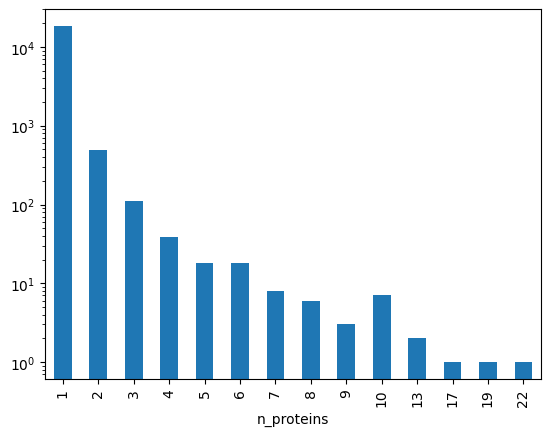

In [18]:
# create a df with clusters as entry
uniref_df = uniprot_id_mapping_df.groupby('External_ID')['UniProtKB_Accession'].apply(list).reset_index()
uniref_df.columns = ['UniRef50_Cluster', 'proteins']

# count
uniref_df["n_proteins"] = uniref_df.proteins.apply(len)
uniref_df.sort_values(by="n_proteins", inplace=True, ascending=False)

# plot
uniref_df.n_proteins.value_counts().sort_index().plot(kind="bar", logy=True)
uniref_df


In [19]:
# Maps proteisn names to gene names
        # ATTENTIon: mapping will have only human  curate genes
uniref_df["genes"] = uniref_df["proteins"].apply(
    lambda lst: [protein_to_gene_map.get(p, None) for p in lst]
)

# Add the 'label' column: 'positive' if at least one protein maps to a positive gene, otherwise 'negative'
uniref_df["cluster_label"] = uniref_df["genes"].apply(
    lambda gene_list: "positive" 
    if any(g in positive_genes for g in gene_list)
    else "negative"
)

# plost how many postive genesets
print(uniref_df["cluster_label"].value_counts())#.sort_index().plot(kind="bar", logy=True,)


uniref_df

cluster_label
negative    18941
positive      218
Name: count, dtype: int64


,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label
11185,UniRef50_Q86YD7,"[Q86YD7, Q658T7, A0A8V8TPE2, A8MXJ8, A6NKC0, A...",22,"[FAM90A1, FAM90A2P, FAM90A3 FAM90A3P, FAM90A5 ...",negative
9925,UniRef50_Q6R6M4,"[Q7RTZ2, Q6R6M4, A6NCW0, A6NCW7, A8MUK1, P0C7H...",19,"[USP17L1 USP17L USP17L1P, USP17L2 DUB3 USP17 U...",negative
7063,UniRef50_Q13066,"[A6NGK3, Q4V321, Q6NT46, Q13066, Q4V326, P0DTW...",17,"[GAGE10, GAGE13 GAGE12A, GAGE2A GAGE2, GAGE2B ...",negative
9177,UniRef50_Q5VXH4,"[O60813, O95522, P0DUQ1, Q5VT98, A6NGN4, H0Y7S...",13,"[PRAMEF11, PRAMEF12, PRAMEF15, PRAMEF20 PRAMEF...",negative
18902,UniRef50_Q9Y5E9,"[Q9Y5E7, Q9Y5E6, Q9Y5E5, Q9Y5E2, Q9UN66, Q9Y5E...",13,"[PCDHB2, PCDHB3, PCDHB4, PCDHB7, PCDHB8 PCDH3I...",negative
...,...,...,...,...,...
6588,UniRef50_Q02078,[Q02078],1,[MEF2A MEF2],negative
6587,UniRef50_Q02067,[P50553],1,[ASCL1 ASH1 BHLHA46 HASH1],negative
6586,UniRef50_Q02045,[Q02045],1,[MYL5],negative
6585,UniRef50_Q02040,[Q02040],1,[AKAP17A CXYorf3 DXYS155E SFRS17A XE7],negative


,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label,proteins_positive,genes_positive,n_genes_positive
3202,UniRef50_P08476,[P08476],1,[INHBA],positive,[P08476],[INHBA],1
15387,UniRef50_Q9BUF5,[Q9BUF5],1,[TUBB6],positive,[Q9BUF5],[TUBB6],1
11238,UniRef50_Q8BJS8,[Q96DY7],1,[MTBP],positive,[Q96DY7],[MTBP],1
5370,UniRef50_P49454,[P49454],1,[CENPF],positive,[P49454],[CENPF],1
5369,UniRef50_P49450,[P49450],1,[CENPA],positive,[P49450],[CENPA],1


(19159, 8)

<Axes: xlabel='n_genes_positive'>

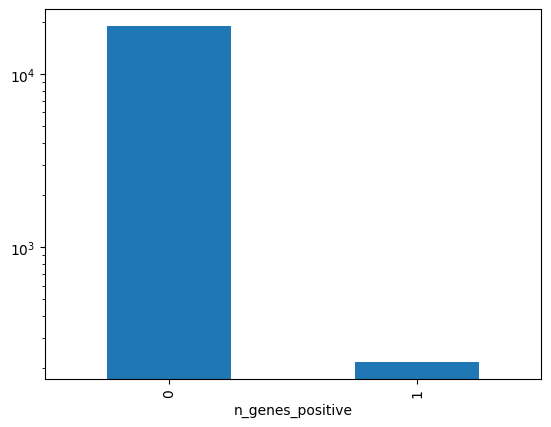

In [20]:
# create list of genes AND CORREPSONDET prots that are postive (from above)

# unzip in parallel pritens_clened and genes_clened and create ritens_clened_psotive and genes_clened_positive 
    # maintain if proteins comes form psotive gene
uniref_df["proteins_positive"], uniref_df["genes_positive"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["proteins"], row["genes"]) if g in positive_genes],
        [g for g in row["genes"] if g in positive_genes]
    ),
    axis=1
))
uniref_df["n_genes_positive"] = uniref_df["genes_positive"].apply(len)
uniref_df.sort_values(by="n_genes_positive", ascending=False, inplace=True)

display(uniref_df.head(5))
display(uniref_df.shape)
uniref_df.n_genes_positive.value_counts().plot(kind="bar", logy=True)

In [ ]:
# # give probablities to be samped to each protein
# uniref_df["logits"] = uniref_df["genes_positive"].apply(
#     lambda gene_list: [positive_gene_freq_map.get(g, 0) for g in gene_list]
# )
# def safe_softmax(logits):
#     if len(logits) == 0:
#         return []  # return empty list if no logits
#     return softmax(logits).tolist()  # convert numpy array to list
# uniref_df["probs"] = uniref_df["logits"].apply(safe_softmax)

# uniref_df

,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs
3202,UniRef50_P08476,[P08476],1,[INHBA],positive,[P08476],[INHBA],1,[3],[1.0]
15387,UniRef50_Q9BUF5,[Q9BUF5],1,[TUBB6],positive,[Q9BUF5],[TUBB6],1,[5],[1.0]
11238,UniRef50_Q8BJS8,[Q96DY7],1,[MTBP],positive,[Q96DY7],[MTBP],1,[6],[1.0]
5370,UniRef50_P49454,[P49454],1,[CENPF],positive,[P49454],[CENPF],1,[11],[1.0]
5369,UniRef50_P49450,[P49450],1,[CENPA],positive,[P49450],[CENPA],1,[6],[1.0]
...,...,...,...,...,...,...,...,...,...,...
18777,UniRef50_Q9Y3Q0,[Q9Y3Q0],1,[NAALAD2],negative,[],[],0,[],[]
18778,UniRef50_Q9Y3Q3,[Q9Y3Q3],1,[TMED3 C15orf22 UNQ5357/PRO1078],negative,[],[],0,[],[]
18779,UniRef50_Q9Y3Q4,[Q9Y3Q4],1,[HCN4],negative,[],[],0,[],[]
18780,UniRef50_Q9Y3Q7,[Q9Y3Q7],1,[ADAM18 TMDC3 UNQ858/PRO1867],negative,[],[],0,[],[]


In [22]:
# Create list of putative negative genes/protein        
    # putatove = neither postive neither ambigous
gene_to_exclude = ambiguos_genes.union(positive_genes)

uniref_df["putative_negative_proteins"], uniref_df["putative_negative_genes"] = zip(*uniref_df.apply(
    lambda row: (
        [p for p, g in zip(row["proteins"], row["genes"]) if g not in gene_to_exclude],
        [g for g in row["genes"] if g not in gene_to_exclude]
    ),
    axis=1
))

uniref_df["n_putative_negative_genes"] = uniref_df.putative_negative_genes.apply(len)

display(uniref_df.tail(5))


,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes
18777,UniRef50_Q9Y3Q0,[Q9Y3Q0],1,[NAALAD2],negative,[],[],0,[],[],[Q9Y3Q0],[NAALAD2],1
18778,UniRef50_Q9Y3Q3,[Q9Y3Q3],1,[TMED3 C15orf22 UNQ5357/PRO1078],negative,[],[],0,[],[],[Q9Y3Q3],[TMED3 C15orf22 UNQ5357/PRO1078],1
18779,UniRef50_Q9Y3Q4,[Q9Y3Q4],1,[HCN4],negative,[],[],0,[],[],[Q9Y3Q4],[HCN4],1
18780,UniRef50_Q9Y3Q7,[Q9Y3Q7],1,[ADAM18 TMDC3 UNQ858/PRO1867],negative,[],[],0,[],[],[Q9Y3Q7],[ADAM18 TMDC3 UNQ858/PRO1867],1
18808,UniRef50_Q9Y478,[Q9Y478],1,[PRKAB1 AMPK],negative,[],[],0,[],[],[Q9Y478],[PRKAB1 AMPK],1


## Positive class sampling


In [ ]:
def sample_sampled_from_single_row(row, min_sample_n, prot_col, gene_col, probs_col):

    N = min(len(row[prot_col]), min_sample_n)

    if probs_col != None:
        probs = row[probs_col] #use precompued prbs
    else:
        probs=None # unirform prob

    # sample indices
    sampled_indices = np.random.choice(len(row[prot_col]), size=N, replace=False, p=probs) 

    # covert to array
    proteins_array = np.array(row[prot_col])
    genes_array = np.array(row[gene_col])

    # return sliced
    return proteins_array[sampled_indices], genes_array[sampled_indices]

In [23]:
# Filter only positive clusters
uniref_df_pos = uniref_df[uniref_df.cluster_label == "positive"].copy()

# Take ALL psotive (not sample)
uniref_df_pos["proteins_sampled"] = uniref_df_pos["proteins_positive"]
uniref_df_pos["genes_sampled"] =  uniref_df_pos["genes_positive"]
uniref_df_pos["n_proteins_sampled"] = uniref_df_pos.proteins_sampled.apply(len)

uniref_df_pos

,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,proteins_sampled,genes_sampled,n_proteins_sampled
3202,UniRef50_P08476,[P08476],1,[INHBA],positive,[P08476],[INHBA],1,[3],[1.0],[],[],0,[P08476],[INHBA],1
15387,UniRef50_Q9BUF5,[Q9BUF5],1,[TUBB6],positive,[Q9BUF5],[TUBB6],1,[5],[1.0],[],[],0,[Q9BUF5],[TUBB6],1
11238,UniRef50_Q8BJS8,[Q96DY7],1,[MTBP],positive,[Q96DY7],[MTBP],1,[6],[1.0],[],[],0,[Q96DY7],[MTBP],1
5370,UniRef50_P49454,[P49454],1,[CENPF],positive,[P49454],[CENPF],1,[11],[1.0],[],[],0,[P49454],[CENPF],1
5369,UniRef50_P49450,[P49450],1,[CENPA],positive,[P49450],[CENPA],1,[6],[1.0],[],[],0,[P49450],[CENPA],1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2456,UniRef50_O95229,[O95229],1,[ZWINT],positive,[O95229],[ZWINT],1,[6],[1.0],[],[],0,[O95229],[ZWINT],1
288,UniRef50_A0AVK6,[A0AVK6],1,[E2F8],positive,[A0AVK6],[E2F8],1,[4],[1.0],[],[],0,[A0AVK6],[E2F8],1
4682,UniRef50_P31323,[P31323],1,[PRKAR2B],positive,[P31323],[PRKAR2B],1,[4],[1.0],[],[],0,[P31323],[PRKAR2B],1
9118,UniRef50_Q5VTD9,[Q5VTD9],1,[GFI1B],positive,[Q5VTD9],[GFI1B],1,[3],[1.0],[],[],0,[Q5VTD9],[GFI1B],1


## Negative class sampling

In [29]:
# Filter only positive clusters
    # sample from ONLY NEGATIVE --> no over,ap
    # but they shiudl have at least 1 neagtive protein
uniref_df_neg = uniref_df[(uniref_df.n_putative_negative_genes > 0) & (uniref_df.cluster_label == "negative")].copy() 

uniref_df_neg["proteins_sampled"], uniref_df_neg["genes_sampled"] = zip(
    *uniref_df_neg.apply(
            sample_sampled_from_single_row, 
            axis=1, 
            min_sample_n=MIN_SAMPLE_N_POSITIVE, 
            gene_col="putative_negative_genes", 
            prot_col="putative_negative_proteins", 
            probs_col=None # uniform
            )
)
uniref_df_neg["n_proteins_sampled"] = uniref_df_neg.proteins_sampled.apply(len)

# ATTENTION: same clusters coudl have 0 proteins to sample from (all proteins are postive OR ambigous so nothing left to sample as negative)
uniref_df_neg = uniref_df_neg[uniref_df_neg.n_proteins_sampled > 0]

display(uniref_df_neg.head())
print(uniref_df_neg.shape)

,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,proteins_sampled,genes_sampled,n_proteins_sampled
174,UniRef50_A0A1B0GUA9,[A0A1B0GUA9],1,[C13orf46],negative,[],[],0,[],[],[A0A1B0GUA9],[C13orf46],1,[A0A1B0GUA9],[C13orf46],1
201,UniRef50_A0A1B0GVM6,[A0A1B0GVM6],1,[C11orf97],negative,[],[],0,[],[],[A0A1B0GVM6],[C11orf97],1,[A0A1B0GVM6],[C11orf97],1
199,UniRef50_A0A1B0GVK7,[A0A1B0GVK7],1,[FAM240A],negative,[],[],0,[],[],[A0A1B0GVK7],[FAM240A],1,[A0A1B0GVK7],[FAM240A],1
200,UniRef50_A0A1B0GVM5,[A0A1B0GVM5],1,[ETDC],negative,[],[],0,[],[],[A0A1B0GVM5],[ETDC],1,[A0A1B0GVM5],[ETDC],1
170,UniRef50_A0A1B0GU71,[A0A1B0GU71],1,[CFAP97D2],negative,[],[],0,[],[],[A0A1B0GU71],[CFAP97D2],1,[A0A1B0GU71],[CFAP97D2],1


(18042, 16)


## Make dataset

Final df shoudl be:
- | Cluster | protein name | label | seq |

In [36]:
# add labels
uniref_df_pos["label_single_prot"] = 1
uniref_df_neg["label_single_prot"] = 0

# merge --> each entry is a cluster
dataset_df = pd.concat([uniref_df_pos, uniref_df_neg])
display(dataset_df.head())


,UniRef50_Cluster,proteins,n_proteins,genes,cluster_label,proteins_positive,genes_positive,n_genes_positive,logits,probs,putative_negative_proteins,putative_negative_genes,n_putative_negative_genes,proteins_sampled,genes_sampled,n_proteins_sampled,label_single_prot
3202,UniRef50_P08476,[P08476],1,[INHBA],positive,[P08476],[INHBA],1,[3],[1.0],[],[],0,[P08476],[INHBA],1,1
15387,UniRef50_Q9BUF5,[Q9BUF5],1,[TUBB6],positive,[Q9BUF5],[TUBB6],1,[5],[1.0],[],[],0,[Q9BUF5],[TUBB6],1,1
11238,UniRef50_Q8BJS8,[Q96DY7],1,[MTBP],positive,[Q96DY7],[MTBP],1,[6],[1.0],[],[],0,[Q96DY7],[MTBP],1,1
5370,UniRef50_P49454,[P49454],1,[CENPF],positive,[P49454],[CENPF],1,[11],[1.0],[],[],0,[P49454],[CENPF],1,1
5369,UniRef50_P49450,[P49450],1,[CENPA],positive,[P49450],[CENPA],1,[6],[1.0],[],[],0,[P49450],[CENPA],1,1


In [37]:
# smaller df
cols_to_keep = ['UniRef50_Cluster', 'proteins_sampled',
                'genes_sampled', 'label_single_prot']
dataset_df_small = dataset_df[cols_to_keep].copy()

display(dataset_df_small)
print("ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins")
print(len(set(gene for sublist in dataset_df_small['proteins_sampled'] for gene in sublist)), "/ 20000")

# Create a new DataFrame where each row corresponds to a (protein, gene) pair
rows = []
for _, row in dataset_df_small.iterrows():
    cluster = row["UniRef50_Cluster"]
    label = row["label_single_prot"]
    proteins = row["proteins_sampled"]
    genes = row["genes_sampled"]

    # zip ensures 1-to-1 pairing between proteins and genes
    for prot, gene in zip(proteins, genes):
        rows.append({
            "UniRef50_Cluster": cluster,
            "protein": prot,
            "gene": gene,
            "label": label
        })

df_long = pd.DataFrame(rows)

# checj fro duplcates
print("\nDuplicated rows/proteins: ", df_long.shape[0] - df_long.protein.nunique())

df_long

,UniRef50_Cluster,proteins_sampled,genes_sampled,label_single_prot
3202,UniRef50_P08476,[P08476],[INHBA],1
15387,UniRef50_Q9BUF5,[Q9BUF5],[TUBB6],1
11238,UniRef50_Q8BJS8,[Q96DY7],[MTBP],1
5370,UniRef50_P49454,[P49454],[CENPF],1
5369,UniRef50_P49450,[P49450],[CENPA],1
...,...,...,...,...
18777,UniRef50_Q9Y3Q0,[Q9Y3Q0],[NAALAD2],0
18778,UniRef50_Q9Y3Q3,[Q9Y3Q3],[TMED3 C15orf22 UNQ5357/PRO1078],0
18779,UniRef50_Q9Y3Q4,[Q9Y3Q4],[HCN4],0
18780,UniRef50_Q9Y3Q7,[Q9Y3Q7],[ADAM18 TMDC3 UNQ858/PRO1867],0


ATTENTION: the number of proteins sampled is less than the total ~20000 of Swissport, as we subsampled only N, so we may have lsot some proteins
18927 / 20000

Duplicated rows/proteins:  0


,UniRef50_Cluster,protein,gene,label
0,UniRef50_P08476,P08476,INHBA,1
1,UniRef50_Q9BUF5,Q9BUF5,TUBB6,1
2,UniRef50_Q8BJS8,Q96DY7,MTBP,1
3,UniRef50_P49454,P49454,CENPF,1
4,UniRef50_P49450,P49450,CENPA,1
...,...,...,...,...
18922,UniRef50_Q9Y3Q0,Q9Y3Q0,NAALAD2,0
18923,UniRef50_Q9Y3Q3,Q9Y3Q3,TMED3 C15orf22 UNQ5357/PRO1078,0
18924,UniRef50_Q9Y3Q4,Q9Y3Q4,HCN4,0
18925,UniRef50_Q9Y3Q7,Q9Y3Q7,ADAM18 TMDC3 UNQ858/PRO1867,0


# Assure 1:3 ratio in postive and negative class
After this sampling you will have (done LATER in notebook)
- | pos prot | << | neg prot | → more thna 1:3 ration
- Need to subsampled negative class
- Subsample negative class
    - Retain all proteins that comes form clusters that have a positive protein
    - Subsample the remaining cluster to have a final ratio 1:3

In [39]:
# list of smpled positve proteins
positive_proteins_tmp = set(df_long[df_long.label == 1]["protein"].unique())

# list of prtein in MIXED cluster (wiht inside btoh postive and negative prteins)
    # ATTENTUON: check no ptortien in mixed clusters
proteins_in_mixed_clusters = df_long.groupby('UniRef50_Cluster').filter(lambda x: x['label'].nunique() > 1).sort_values(by="UniRef50_Cluster")
print("priteins in mixed clusters:", len(proteins_in_mixed_clusters))
proteins_in_mixed_clusters = set(proteins_in_mixed_clusters["protein"].unique())

# proteins to NOT remove
proteins_not_to_remove = proteins_in_mixed_clusters.union(positive_proteins_tmp)

# give col
df_long["can_be_removed"] = ~df_long["protein"].isin(proteins_not_to_remove)

df_long

priteins in mixed clusters: 0


,UniRef50_Cluster,protein,gene,label,can_be_removed
0,UniRef50_P08476,P08476,INHBA,1,False
1,UniRef50_Q9BUF5,Q9BUF5,TUBB6,1,False
2,UniRef50_Q8BJS8,Q96DY7,MTBP,1,False
3,UniRef50_P49454,P49454,CENPF,1,False
4,UniRef50_P49450,P49450,CENPA,1,False
...,...,...,...,...,...
18922,UniRef50_Q9Y3Q0,Q9Y3Q0,NAALAD2,0,True
18923,UniRef50_Q9Y3Q3,Q9Y3Q3,TMED3 C15orf22 UNQ5357/PRO1078,0,True
18924,UniRef50_Q9Y3Q4,Q9Y3Q4,HCN4,0,True
18925,UniRef50_Q9Y3Q7,Q9Y3Q7,ADAM18 TMDC3 UNQ858/PRO1867,0,True


In [40]:
# decide fraction to susample

# Number of positive proteins
n_positive = df_long[df_long["label"] == 1].shape[0]
# Number desidered negative
n_desired_negatives = n_positive * NEGATIVE_CLASS_MULT
# Removable (negative) proteins
removable_negatives = df_long[(df_long["label"] == 0) & (df_long["can_be_removed"])]
# Determine fraction to subsample
frac_to_sample = n_desired_negatives / len(removable_negatives)
frac_to_sample = min(frac_to_sample, 1.0)  # cannot sample more than available

frac_to_sample

0.034956438077930405

In [41]:

# susample
removable = df_long[df_long["can_be_removed"]]
keep = df_long[~df_long["can_be_removed"]]

subsampled_removable = removable.sample(frac=frac_to_sample, random_state=SEED)

df_subsampled = pd.concat([keep, subsampled_removable]).reset_index(drop=True) # Combine back with the protected proteins

print(df_subsampled.label.value_counts())
df_subsampled

label
0    654
1    218
Name: count, dtype: int64


,UniRef50_Cluster,protein,gene,label,can_be_removed
0,UniRef50_P08476,P08476,INHBA,1,False
1,UniRef50_Q9BUF5,Q9BUF5,TUBB6,1,False
2,UniRef50_Q8BJS8,Q96DY7,MTBP,1,False
3,UniRef50_P49454,P49454,CENPF,1,False
4,UniRef50_P49450,P49450,CENPA,1,False
...,...,...,...,...,...
867,UniRef50_Q96R54,Q96R54,OR14A2 OR5AX1 OR5AX1P,0,True
868,UniRef50_O00241,O00241,SIRPB1,0,True
869,UniRef50_Q9Y5G9,Q9Y5G9,PCDHGA4,0,True
870,UniRef50_P43360,P43358,MAGEA4 MAGE4,0,True


## Give Seq


In [42]:
### create df to join
join_df_tmp = proteome_uniprot[["Entry", "Sequence"]].copy().rename(columns={"Sequence": "sequence"})

# join
    # ATTNETION: we shoudl NOT lose any col
long_df_seq = pd.merge(how="inner", left=df_subsampled, right=join_df_tmp, left_on="protein", right_on="Entry")

# drp cols
long_df_seq.drop(columns=["can_be_removed", "Entry"], inplace=True)

long_df_seq

,UniRef50_Cluster,protein,gene,label,sequence
0,UniRef50_P08476,P08476,INHBA,1,MPLLWLRGFLLASCWIIVRSSPTPGSEGHSAAPDCPSCALAALPKD...
1,UniRef50_Q9BUF5,Q9BUF5,TUBB6,1,MREIVHIQAGQCGNQIGTKFWEVISDEHGIDPAGGYVGDSALQLER...
2,UniRef50_Q8BJS8,Q96DY7,MTBP,1,MDRYLLLVIWGEGKFPSAASREAEHGPEVSSGEGTENQPDFTAANV...
3,UniRef50_P49454,P49454,CENPF,1,MSWALEEWKEGLPTRALQKIQELEGQLDKLKKEKQQRQFQLDSLEA...
4,UniRef50_P49450,P49450,CENPA,1,MGPRRRSRKPEAPRRRSPSPTPTPGPSRRGPSLGASSHQHSRRRQG...
...,...,...,...,...,...
867,UniRef50_Q96R54,Q96R54,OR14A2 OR5AX1 OR5AX1P,0,MANVTLVTGFLLMGFSNIQKLRILYGVLFLLIYLAALMSNLLIITL...
868,UniRef50_O00241,O00241,SIRPB1,0,MPVPASWPHLPSPFLLMTLLLGRLTGVAGEDELQVIQPEKSVSVAA...
869,UniRef50_Q9Y5G9,Q9Y5G9,PCDHGA4,0,MHFILDPEDPGAPQASTEGKPKHRRLRGGVVMAAPPARPDHTRLLQ...
870,UniRef50_P43360,P43358,MAGEA4 MAGE4,0,MSSEQKSQHCKPEEGVEAQEEALGLVGAQAPTTEEQEAAVSSSSPL...


## Stratify dataset

We can stratify based on many metrics:
1. labels
2. PREVALENT metric
3. **based on cluster**
    - Put proteins coming from same cluster in different sets or not

In [44]:
from sklearn.model_selection import train_test_split
import pandas as pd

# --- group-level stratified split ---

# pslit by cluster and then ive back set-label to each row

# One representative row per UniRef50_Cluster
cluster_df = long_df_seq.groupby('UniRef50_Cluster').first().reset_index()

# Stratified split by label, but at the cluster level
    # ists of unique cluster IDs.
train_clusters, temp_clusters = train_test_split(
    cluster_df['UniRef50_Cluster'],
    test_size=0.2,
    stratify=cluster_df['label'],
    random_state=42
)

# Split the temporary set equally into validation and test
temp_labels = cluster_df.loc[cluster_df['UniRef50_Cluster'].isin(temp_clusters), 'label']
val_clusters, test_clusters = train_test_split(
    temp_clusters,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

# --- assign back to the full dataframe ---
#Every row in long_df_seq inherits its set label based on its UniRef50_Cluster
long_df_seq['set'] = ''
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(train_clusters), 'set'] = 'train'
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(val_clusters), 'set'] = 'val'
long_df_seq.loc[long_df_seq['UniRef50_Cluster'].isin(test_clusters), 'set'] = 'test'

# Check split distribution
print(long_df_seq.groupby('set')['label'].value_counts().unstack(fill_value=0))
display(long_df_seq)


label    0    1
set            
test    66   22
train  523  174
val     65   22


,UniRef50_Cluster,protein,gene,label,sequence,set
0,UniRef50_P08476,P08476,INHBA,1,MPLLWLRGFLLASCWIIVRSSPTPGSEGHSAAPDCPSCALAALPKD...,train
1,UniRef50_Q9BUF5,Q9BUF5,TUBB6,1,MREIVHIQAGQCGNQIGTKFWEVISDEHGIDPAGGYVGDSALQLER...,train
2,UniRef50_Q8BJS8,Q96DY7,MTBP,1,MDRYLLLVIWGEGKFPSAASREAEHGPEVSSGEGTENQPDFTAANV...,train
3,UniRef50_P49454,P49454,CENPF,1,MSWALEEWKEGLPTRALQKIQELEGQLDKLKKEKQQRQFQLDSLEA...,train
4,UniRef50_P49450,P49450,CENPA,1,MGPRRRSRKPEAPRRRSPSPTPTPGPSRRGPSLGASSHQHSRRRQG...,val
...,...,...,...,...,...,...
867,UniRef50_Q96R54,Q96R54,OR14A2 OR5AX1 OR5AX1P,0,MANVTLVTGFLLMGFSNIQKLRILYGVLFLLIYLAALMSNLLIITL...,train
868,UniRef50_O00241,O00241,SIRPB1,0,MPVPASWPHLPSPFLLMTLLLGRLTGVAGEDELQVIQPEKSVSVAA...,train
869,UniRef50_Q9Y5G9,Q9Y5G9,PCDHGA4,0,MHFILDPEDPGAPQASTEGKPKHRRLRGGVVMAAPPARPDHTRLLQ...,train
870,UniRef50_P43360,P43358,MAGEA4 MAGE4,0,MSSEQKSQHCKPEEGVEAQEEALGLVGAQAPTTEEQEAAVSSSSPL...,train


# Optional: add precomputed protein embs

In [26]:
#long_df_seq["embedding"] = [[] for _ in range(len(long_df_seq))]

## Save

In [45]:
long_df_seq.to_csv(FINAL_DATASET_PATH)
FINAL_DATASET_PATH

'/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/gabri_dataset-cell-cycle_2:3.csv'

# ------------------------------

In [35]:
from Bio import SeqIO
import pandas as pd

# Parse all sequences in the FASTA file
records = list(SeqIO.parse("/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/0_class_yu_et_all.fasta", "fasta"))
data = {
    "protein": [record.id for record in records],
    "sequence": [str(record.seq) for record in records],
    "label": [0 for record in records],
}
df_neg = pd.DataFrame(data)
print(df_neg.shape)


records = list(SeqIO.parse("/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/1_class_yu_et_all.fasta", "fasta"))
data = {
    "protein": [record.id for record in records],
    "sequence": [str(record.seq) for record in records],
    "label": [1 for record in records],
}
df_pos = pd.DataFrame(data)
print(df_pos.shape)

df = pd.concat([df_neg, df_pos])

df


(167, 3)
(166, 3)


,protein,sequence,label
0,N|0|training,MVWCKHCAKNVPKIRPFDGGLACDLCGRILENFNFSTDVTFVKNAA...,0
1,N|0|training,MRMLIFTYKLERYIKNKILPKILVVPDRDKYQIKGSFRRRIPYITD...,0
2,N|0|training,MPPKTPRKTAATAAAAAAEPPAPPPPPPPEEDPEQDSGPEDLPLVR...,0
3,N|0|training,MSHHSETILTAILNTKYLENGSKHKIIELPKTNIKKLIKDFLSVNS...,0
4,N|0|training,MSIAGVAAQEIRVPLKTGFLHNGRAMGNMRKTYWSSRSEFKNNFLN...,0
...,...,...,...
161,P|1|training,MELFCLEKDTVVRAQKDPNIFCDERVLQSLLTVEDRYVPQGPYFKC...,1
162,P|1|training,MAIHHHHHNHQQLQQHTSSLFDALYCDEEEKWEDDDEGEVVDEGAQ...,1
163,P|1|training,MDRASENRRLAAVGKPVPGIGEMGNRRPLRDINNLVGAPSHPSAIA...,1
164,P|1|training,MSQFAIHQDVENQVPRRGKAANTRTVTQGQKRAVLGVITNQANQPN...,1


In [37]:
train_idx, test_idx = train_test_split(
    df.index,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)

# Assign splits
df['set'] = ''
df.loc[train_idx, 'set'] = 'train'
df.loc[test_idx, 'set'] = 'test'
df.loc[test_idx[0], 'set'] = 'val' #just temp
df.reset_index(drop=True, inplace=True)
df["protein"] = range(df["protein"].shape[0])

print(df.groupby('set')['label'].value_counts().unstack(fill_value=0))
display(df)
df

label    0    1
set            
test    33   33
train  133  133
val      1    0


,protein,sequence,label,set
0,0,MVWCKHCAKNVPKIRPFDGGLACDLCGRILENFNFSTDVTFVKNAA...,0,train
1,1,MRMLIFTYKLERYIKNKILPKILVVPDRDKYQIKGSFRRRIPYITD...,0,test
2,2,MPPKTPRKTAATAAAAAAEPPAPPPPPPPEEDPEQDSGPEDLPLVR...,0,train
3,3,MSHHSETILTAILNTKYLENGSKHKIIELPKTNIKKLIKDFLSVNS...,0,train
4,4,MSIAGVAAQEIRVPLKTGFLHNGRAMGNMRKTYWSSRSEFKNNFLN...,0,train
...,...,...,...,...
328,328,MELFCLEKDTVVRAQKDPNIFCDERVLQSLLTVEDRYVPQGPYFKC...,1,train
329,329,MAIHHHHHNHQQLQQHTSSLFDALYCDEEEKWEDDDEGEVVDEGAQ...,1,train
330,330,MDRASENRRLAAVGKPVPGIGEMGNRRPLRDINNLVGAPSHPSAIA...,1,train
331,331,MSQFAIHQDVENQVPRRGKAANTRTVTQGQKRAVLGVITNQANQPN...,1,test


,protein,sequence,label,set
0,0,MVWCKHCAKNVPKIRPFDGGLACDLCGRILENFNFSTDVTFVKNAA...,0,train
1,1,MRMLIFTYKLERYIKNKILPKILVVPDRDKYQIKGSFRRRIPYITD...,0,test
2,2,MPPKTPRKTAATAAAAAAEPPAPPPPPPPEEDPEQDSGPEDLPLVR...,0,train
3,3,MSHHSETILTAILNTKYLENGSKHKIIELPKTNIKKLIKDFLSVNS...,0,train
4,4,MSIAGVAAQEIRVPLKTGFLHNGRAMGNMRKTYWSSRSEFKNNFLN...,0,train
...,...,...,...,...
328,328,MELFCLEKDTVVRAQKDPNIFCDERVLQSLLTVEDRYVPQGPYFKC...,1,train
329,329,MAIHHHHHNHQQLQQHTSSLFDALYCDEEEKWEDDDEGEVVDEGAQ...,1,train
330,330,MDRASENRRLAAVGKPVPGIGEMGNRRPLRDINNLVGAPSHPSAIA...,1,train
331,331,MSQFAIHQDVENQVPRRGKAANTRTVTQGQKRAVLGVITNQANQPN...,1,test


In [38]:
df.iloc[[332]].sequence.to_list()

['MSFAFSENPLTYDVENSQNAGPQTRKTKREDAGRGNGPQACKRAALGTLSTNVTRKQPSRAAKQSGFADGFYNYQDENAFARPAAGKSTGSCGFALPPTASQPSFSIHIDPVEPAPSRARFLKEQKPTELPLDPIGYFVTRSRKTALRTVFTLDESASPMVLDTSLSEENTAQATIEDIDNSDGVFGVPEYAEDIYEYLREAELRNRPKPGYMRKQPDITSGMRSILVDWLIEVGEEYRLHNETLYLAVSYIDRFLSQMSVLRSKLQLVGAASMFLAAKFEEIYPPEVNEFVYITDDTYTVKQVLRMEHLILKVLSFDVAVPTANAFLSRYLKAAKADSRNGTSSQYLAELTLPDCEYIKYIPSTIAAAAVCLANYTLSGTAWTPMLEKHSGYNLEDIAPCVRDLLKTFTNAPSQSQQAAQEKYKSQRYNSVSMIAAPTTLPSWL']

In [39]:
df.to_csv("/home/gdallagl/myworkdir/ESMSec/data/cell_cycle/yu_et_all_cyclins.csv")